# Agent Chat with Multi-Modality Models

We use **LLaVA** as an example for the multi-modality feature.  More information about LLaVA can be found in their [GitHub page](https://github.com/haotian-liu/LLaVA)


This notebook contains the following information and examples:

1. Setup LLaVA 
    - Option 1: Use API calls from `Replicate`
    - Option 2: Setup LLaVA locally (requires GPU)
2. Application 1: Garden helper
3. Application 2: Image Regeneration

In [1]:
# We use this variable to control where you want to host LLaVA, locally or remotely?
# More details in the two setup options below.

LLAVA_MODE = "local" # Either "local" or "remote"

assert LLAVA_MODE in ["local", "remote"]

# (Option 1, preferred) Use API Calls from Replicate [Remote]
We can also use [Replicate](https://replicate.com/yorickvp/llava-13b/api) to use LLaVA directly, which will host the model for you.

1. Run `pip install replicate` to install the package
2. You need to get an API key from Replicate from your [account setting page](https://replicate.com/account/api-tokens)
3. Next, copy your API token and authenticate by setting it as an environment variable:
    `export REPLICATE_API_TOKEN=<paste-your-token-here>` 
4. You need to enter your credit card information for Replicate 🥲
    

In [2]:
# pip install replicate
# import os
## alternatively, you can put your API key here for the environment variable.
# os.environ["REPLICATE_API_TOKEN"] = "r8_xyz your api key goes here~"

In [3]:
import replicate


In [4]:
# img = get_image_data("https://github.com/haotian-liu/LLaVA/raw/main/images/llava_logo.png", use_b64=True)
# img = 'data:image/jpeg;base64,' + img

# response = replicate.run(
#     "yorickvp/llava-13b:2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591",
#     input={"image": img,
#            "prompt": "Describe the in poetry."}
# )
# output = ""
# for item in response:
#     output += item
# print(output)

## [Option 2] Setup LLaVA Locally
Please follow the LLaVA GitHub [page](https://github.com/haotian-liu/LLaVA/) to install LLaVA, download the weights, and start the server.

For instance, here are some important steps:
```bash
# Download the package
git clone https://github.com/haotian-liu/LLaVA.git
cd LLaVA

# Install the inference package
conda create -n llava python=3.10 -y
conda activate llava
pip install --upgrade pip  # enable PEP 660 support
pip install -e .

# Download and serve the model
python -m llava.serve.model_worker --host 0.0.0.0 --controller http://localhost:10000 --port 40000 --worker http://localhost:40000 --model-path liuhaotian/llava-v1.5-7b
```

Some helpful packages and dependencies:
```bash
conda install -c nvidia cuda-toolkit
```


### Launch

In one terminal, start the controller first:
```bash
python -m llava.serve.controller --host 0.0.0.0 --port 10000
```


Then, in another terminal, start the worker, which will load the model to the GPU:
```bash
python -m llava.serve.model_worker --host 0.0.0.0 --controller http://localhost:10000 --port 40000 --worker http://localhost:40000 --model-path liuhaotian/llava-v1.5-13b
``

**Note: make sure the environment of this notebook also installed the llava package from `pip install -e .`**

In [5]:
# Run this code block only if you want to run LlaVA locally
import requests
import json
from llava.conversation import default_conversation as conv
from llava.conversation import Conversation

# Setup some global constants for convenience
# Note: make sure the addresses below are consistent with your setup in LLaVA 
CONTROLLER_ADDR = "http://0.0.0.0:10000"
SEP =  conv.sep
ret = requests.post(CONTROLLER_ADDR + "/list_models")
print(ret.json())
MODEL_NAME = ret.json()["models"][0]
print("Model Name:", MODEL_NAME)

[2023-10-18 13:49:01,342] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)
{'models': ['llava-v1.5-13b']}
Model Name: llava-v1.5-13b


# Multi-Modal Functions

The Multi-Modal Functions library provides a set of utilities to manage and process multi-modal data, focusing on textual and image components. The library allows you to format prompts, extract image paths, and handle image data in various formats.

## Functions


### `get_image_data`

This function retrieves the content of an image specified by a file path or URL and optionally converts it to base64 format. It can handle both web-hosted images and locally stored files.


### `lmm_formater`

This function formats a user-provided prompt containing `<img ...>` tags, replacing these tags with `<image>` or numbered versions like `<image 1>`, `<image 2>`, etc., and extracts the image locations. It returns a tuple containing the new formatted prompt and a list of image data.

In [6]:
import base64
import re
from io import BytesIO

from PIL import Image

import re
from typing import List, Tuple


def get_image_data(image_file, use_b64=True):
    if image_file.startswith('http://') or image_file.startswith('https://'):
        response = requests.get(image_file)
        content = response.content
    elif re.match(r"data:image/(?:png|jpeg);base64,", image_file):
        return re.sub(r"data:image/(?:png|jpeg);base64,", "", image_file)
    else:
        image = Image.open(image_file).convert('RGB')
#         content = open(image_file, "rb").read()
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        content = buffered.getvalue()
        
    if use_b64:
        return base64.b64encode(content).decode('utf-8')
    else:
        return content

def lmm_formater(prompt: str, order_image_tokens: bool = False) -> Tuple[str, List[str]]:
    """
    Formats the input prompt by replacing image tags and returns the new prompt along with image locations.
    
    Parameters:
        - prompt (str): The input string that may contain image tags like <img ...>.
        - order_image_tokens (bool, optional): Whether to order the image tokens with numbers. 
            It will be useful for GPT-4V. Defaults to False.
    
    Returns:
        - Tuple[str, List[str]]: A tuple containing the formatted string and a list of images (loaded in b64 format).
    """
    
    # Initialize variables
    new_prompt = prompt
    image_locations = []
    images = []
    image_count = 0
    
    # Regular expression pattern for matching <img ...> tags
    img_tag_pattern = re.compile(r'<img ([^>]+)>')
    
    # Find all image tags
    for match in img_tag_pattern.finditer(prompt):
        image_location = match.group(1)
        
        try: 
            img_data = get_image_data(image_location)
        except:
            # Remove the token
            print(f"Warning! Unable to load image from {image_location}")
            new_prompt = new_prompt.replace(match.group(0), "", 1)
            continue
        
        image_locations.append(image_location)
        images.append(img_data)
        
        # Increment the image count and replace the tag in the prompt
        new_token = f'<image {image_count}>' if  order_image_tokens else "<image>"

        new_prompt = new_prompt.replace(match.group(0), new_token, 1)
        image_count += 1
        
    return new_prompt, images




def extract_img_paths(paragraph: str) -> list:
    """
    Extract image paths (URLs or local paths) from a text paragraph.
    
    Parameters:
        paragraph (str): The input text paragraph.
        
    Returns:
        list: A list of extracted image paths.
    """
    # Regular expression to match image URLs and file paths
    img_path_pattern = re.compile(r'\b(?:http[s]?://\S+\.(?:jpg|jpeg|png|gif|bmp)|\S+\.(?:jpg|jpeg|png|gif|bmp))\b', 
                                  re.IGNORECASE)
    
    # Find all matches in the paragraph
    img_paths = re.findall(img_path_pattern, paragraph)
    return img_paths



    
def _to_pil(data):
    return Image.open(BytesIO(base64.b64decode(data)))


def llava_call(prompt:str, model_name: str=MODEL_NAME, images: list=[], max_new_tokens:int=1000, temperature: float=0.5) -> str:
    """
    Makes a call to the LLaVA service to generate text based on a given prompt and optionally provided images.

    Args:
        - prompt (str): The input text for the model. Any image paths or placeholders in the text should be replaced with "<image>".
        - model_name (str, optional): The name of the model to use for the text generation. Defaults to the global constant MODEL_NAME.
        - images (list, optional): A list of image paths or URLs. If not provided, they will be extracted from the prompt.
            If provided, they will be appended to the prompt with the "<image>" placeholder.
        - max_new_tokens (int, optional): Maximum number of new tokens to generate. Defaults to 1000.
        - temperature (float, optional): temperature for the model. Defaults to 0.5.

    Returns:
        - str: Generated text from the model.

    Raises:
        - AssertionError: If the number of "<image>" tokens in the prompt and the number of provided images do not match.
        - RunTimeError: If any of the provided images is empty.

    Notes:
    - The function uses global constants: CONTROLLER_ADDR and SEP.
    - Any image paths or URLs in the prompt are automatically replaced with the "<image>" token.
    - If more images are provided than there are "<image>" tokens in the prompt, the extra tokens are appended to the end of the prompt.
    """
    if len(images) == 0:
        prompt, images = lmm_formater(prompt, order_image_tokens=False)
    else:
        # Append the <image> token if missing
        assert prompt.count("<image>") <= len(images), "the number "
        "of image token in prompt and in the images list should be the same!"
        num_token_missing = len(images) - prompt.count("<image>")
        prompt += " <image> " * num_token_missing
        images = [get_image_data(x) for x in images]
    
    for im in images:
        if len(im) == 0:
            raise RunTimeError("An image is empty!")

    if LLAVA_MODE == "local":
        headers = {"User-Agent": "LLaVA Client"}
        pload = {
            "model": model_name,
            "prompt": prompt,
            "max_new_tokens": max_new_tokens,
            "temperature": temperature,
            "stop": SEP,
            "images": images,
        }

        response = requests.post(CONTROLLER_ADDR + "/worker_generate_stream", headers=headers,
                json=pload, stream=False)

        for chunk in response.iter_lines(chunk_size=8192, decode_unicode=False, delimiter=b"\0"):
            if chunk:
                data = json.loads(chunk.decode("utf-8"))
                output = data["text"].split(SEP)[-1]
    elif LLAVA_MODE == "remote":
        # The Replicate version of the model only support 1 image for now.
        img = 'data:image/jpeg;base64,' + images[0]
        response = replicate.run(
            "yorickvp/llava-13b:2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591",
            input={"image": img, "prompt": prompt.replace("<image>", " ")}
        )
        # The yorickvp/llava-13b model can stream output as it's running.
        # The predict method returns an iterator, and you can iterate over that output.
        output = ""
        for item in response:
            # https://replicate.com/yorickvp/llava-13b/versions/2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591/api#output-schema
            output += item
        
    # Remove the prompt and the space.
    output = output.replace(prompt, "").strip().rstrip()
    
    return output


Here is the image that we are going to use.

![Image](https://github.com/haotian-liu/LLaVA/raw/main/images/llava_logo.png)

We can call llava by providing the prompt and images separately.


In [7]:
out = llava_call("Describe this image: <image>", 
                 images=["https://github.com/haotian-liu/LLaVA/raw/main/images/llava_logo.png"])
print(out)

Flame red and black toy animal.


Or, we can also call LLaVA with only prompt, with images embedded in the prompt with the <img xxx> format


In [8]:
out = llava_call("Describe this image in one sentence: <img https://github.com/haotian-liu/LLaVA/raw/main/images/llava_logo.png>")
print(out)

In this image, a red toy is standing on its hind legs, looking up. The toy appears to be a combination of a cute animal, possibly a lamb or a donkey, and a fire hydrant, as it has flames coming out of its back. The toy also has glasses on top of its head, giving it a playful and whimsical appearance. The scene is set against a white background, which emphasizes the toy's vibrant colors and unique design.


In [9]:
# out = llava_call("""Criticise the following figure and give constructive feedback so that we can improve the visualization
# ###User: Criticise this image: <img https://github.com/haotian-liu/LLaVA/raw/main/images/llava_logo.png>
# ###""")
# print(out)

## Application 1: Garden Helper

In this section, we present a straightforward dual-agent architecture aimed at facilitating garden management.

We identified an issue in our garden and captured it in the following photograph:
![](http://th.bing.com/th/id/R.105d684e5df7d540e61f6300d0bd374e?rik=PR8LCyvpe93DZA&pid=ImgRaw&r=0)



In [10]:
# Import AutoGen and setup the LLaVAAgent
import autogen
from autogen import AssistantAgent, Agent, UserProxyAgent
from termcolor import colored
import random

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

llm_config = {"config_list": config_list_gpt4, "seed": 42}



class LLaVAAgent(AssistantAgent):
    def __init__(self, img_str_format=None, **kwargs):
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=LLaVAAgent._image_reply, position=0)
        self._img_str_format = img_str_format

    def _image_reply(
        self,
        messages=None,
        sender=None, config=None
    ):
        # Note: we did not use "llm_config" yet.
        # TODO 1: make the LLaVA API design compatible with llm_config
        # TODO 2: the `_image_reply` function should handle input prompt
        #         differently for different `img_str_format`, which will
        #         be valueable for different LMMs.
        # TODO 3: handle the memory and store image data in the memory.
        
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        # The formats for LLaVA and GPT are different. So, we manually handle them here.
        # TODO: format the images from the history accordingly.
        prompt = self.system_message
        for msg in messages:
            role = "Human" if msg["role"] == "user" else "Assistant"
            content = msg["content"]
            prompt += f"{SEP}{role}: {content}"
        prompt += SEP
        print(colored(prompt, "blue"))
    
        out = ""
        retry = 10
        while len(out) == 0 and retry > 0:
            # image names will be inferred automatically from llava_call
            out = llava_call(prompt=prompt, temperature=0, max_new_tokens=2000)
            retry -= 1
            
        assert out != "", "Empty response from LLaVA."
        
        
        return True, out

Within the user proxy agent, we can decide to activate the human input mode or not (for here, we use human_input_mode="NEVER" for conciseness). This allows you to interact with LLaVA in a multi-round dialogue, enabling you to provide feedback as the conversation unfolds.

In [12]:
image_agent = LLaVAAgent(
    name="image-explainer",
    system_message="You are a garden helper. You should describe the image and provide suggestions for the garden.",
    max_consecutive_auto_reply=0
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "groupchat"
    },
    human_input_mode="NEVER", # Try between ALWAYS or NEVER
    llm_config=llm_config,
    max_consecutive_auto_reply=0,
)

# Ask the question with an image
user_proxy.initiate_chat(image_agent, 
                         message="Here is my image: <img http://th.bing.com/th/id/R.105d684e5df7d540e61f6300d0bd374e?rik=PR8LCyvpe93DZA&pid=ImgRaw&r=0>. Can you give me some suggestions?")


User_proxy (to image-explainer):

Here is my image: <img http://th.bing.com/th/id/R.105d684e5df7d540e61f6300d0bd374e?rik=PR8LCyvpe93DZA&pid=ImgRaw&r=0>. Can you give me some suggestions?

--------------------------------------------------------------------------------
You are a garden helper. You should describe the image and provide suggestions for the garden.###Human: Here is my image: <img http://th.bing.com/th/id/R.105d684e5df7d540e61f6300d0bd374e?rik=PR8LCyvpe93DZA&pid=ImgRaw&r=0>. Can you give me some suggestions?###
image-explainer (to User_proxy):

Human: Here is my image: <image>. Can you give me some suggestions?Garden Helper: Based on the image, it appears that the garden is in need of some attention. The strawberries are not in the best condition, with some appearing to be dead or dying. To improve the garden, I would suggest the following:

1. Remove any dead or dying plants, including the strawberries, to prevent the spread of diseases or pests.
2. Assess the soil quality

# Application 2: Figure Critics

In [13]:

class FigureCreator(AssistantAgent):

    def __init__(self, n_iters=2, **kwargs):
        super().__init__(**kwargs)
        self.register_reply([Agent, None],
                            reply_func=FigureCreator._reply_user,
                            position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        user_question = messages[-1]["content"]

        ### Define the agents
        commander = AssistantAgent(
            name="Commander",
            human_input_mode="NEVER",
            max_consecutive_auto_reply=10,
            system_message=
            "Help me run the code, and tell other agents it is in the <img result.jpg> file location.",
            is_termination_msg=lambda x: x.get("content", "").rstrip().endswith(
                "TERMINATE"),
            code_execution_config={
                "last_n_messages": 3,
                "work_dir": ".",
                "use_docker": False
            },
            llm_config=self.llm_config,
        )

        critics = LLaVAAgent(
            name="Critics",
            system_message=
            "Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure.",
            llm_config=self.llm_config,
            human_input_mode="NEVER",
            max_consecutive_auto_reply=0,
            #     use_docker=False,
        )

        coder = AssistantAgent(
            name="Coder",
            llm_config=self.llm_config,
        )

        coder.update_system_message(
            coder.system_message +
            "Save the figure in result.jpg file. Tell other agents it is in the <img result.jpg> file location."
        )

        ### Ask the question with an image
        commander.initiate_chat(coder, message=user_question)

        img = Image.open("result.jpg")
        plt.imshow(img)
        plt.axis('off')  # Hide the axes
        plt.show()
        # commander = AssistantAgent(name="Commander", max_consecutive_auto_reply=0, human_input_mode="NEVER",)

        for i in range(self._n_iters):
            commander.send(message="Improve <img result.jpg>",
                           recipient=critics,
                           request_reply=True)
            commander.send(
                message="Here is the feedback to your figure. Please improve!\n"
                + commander._oai_messages[critics][-1]["content"],
                recipient=coder,
                request_reply=True)
            critics.clear_history(commander)
            img = Image.open("result.jpg")
            plt.imshow(img)
            plt.axis('off')  # Hide the axes
            plt.show()
            
        return True, "result.jpg"

User (to Figure Creator~):


Plot a histogram by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv


--------------------------------------------------------------------------------
Commander (to Coder):


Plot a histogram by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv


--------------------------------------------------------------------------------
Coder (to Commander):

To plot a histogram using the data from the provided URL, we will:

1. Download the CSV file
2. Read the data
3. Plot a histogram using matplotlib

Here's the code to perform these steps:

```python
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Download the CSV file
url = "https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv"
response = requests.get(url)
with open("seattle_weather.csv", "wb") as output:
    output.write(response.content)

# Read the data
data = p

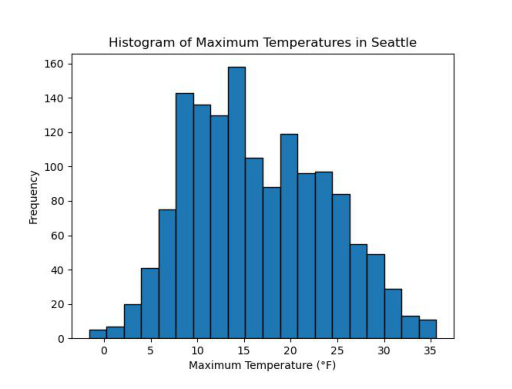

Commander (to Critics):

Improve <img result.jpg>

--------------------------------------------------------------------------------
Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure.###Human: Improve <img result.jpg>###
Critics (to Commander):

Human: Improve <image>Human: Improve 2:

The image shows a histogram of maximum temperatures in Seattle. The histogram is blue and has a few bars. The bars are labeled with the maximum temperature in degrees Fahrenheit. The histogram is not very detailed, as it only shows a few bars. The image could be improved by adding more bars to the histogram to show a wider range of maximum temperatures in Seattle. This would provide a better representation of the distribution of maximum temperatures in the city.

--------------------------------------------------------------------------------
Commander (to Coder):

Here is the feedback to your figure. Please improve!
Human: Improve <image>Human:

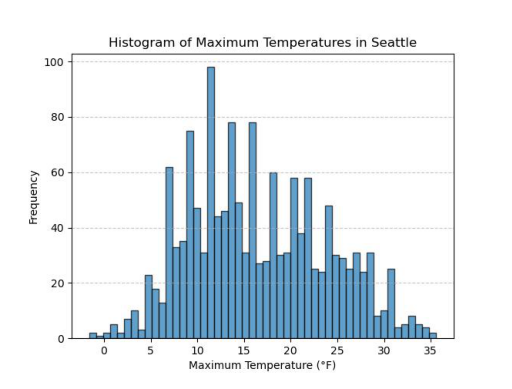

Commander (to Critics):

Improve <img result.jpg>

--------------------------------------------------------------------------------
Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure.###Human: Improve <img result.jpg>###
Critics (to Commander):

Human: Improve <image>Human: Improve 100

The image shows a histogram of maximum temperatures in Seattle. The histogram is blue and has a vertical axis that shows the maximum temperature in degrees Fahrenheit. The horizontal axis shows the frequency of the maximum temperatures. The graph is a representation of the distribution of maximum temperatures in Seattle, with the highest temperature being 100 degrees Fahrenheit.

--------------------------------------------------------------------------------
Commander (to Coder):

Here is the feedback to your figure. Please improve!
Human: Improve <image>Human: Improve 100

The image shows a histogram of maximum temperatures in Seattle. The hi

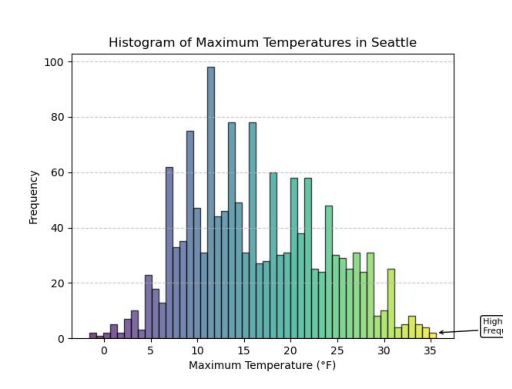

Figure Creator~ (to User):

result.jpg

--------------------------------------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
import time

creator = FigureCreator(
    name="Figure Creator~",
    llm_config=llm_config
    
)

user_proxy = autogen.UserProxyAgent(
    name="User",
    human_input_mode="NEVER",
    llm_config=llm_config,
)

user_proxy.initiate_chat(creator, message="""
Plot a histogram by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv
""")
